# 🚂Predicting the Sale Price of Bulldozers using Machine Learning

## The Goal or Problem Description
* **"Predict the auction sale price for a piece of heavy equipment to create a "blue book" for bulldozers".**

The goal is to try and obtain **a better RMSLE** compared to the best score obtained at in the **Kaggle Competition**.

## Dataset
For Dataset Description see **Kaggle's** [Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers/data). The data for this competition is split into three parts:

* **Train.csv** is the training set, which contains data through the end of 2011.
* **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition

## Evaluation
"The evaluation metric for this competition is the **RMSLE (root mean squared log error)** between the actual and predicted auction prices." See [Evaluation](https://www.kaggle.com/c/bluebook-for-bulldozers/overview) on Kaggle.

## Features
The key fields in **train.csv** are:

* **SalesID**: the uniue identifier of the sale
* **MachineID**: the unique identifier of a machine.  A machine can be sold multiple times
* **saleprice**: what the machine sold for at auction (only provided in train.csv)
* **saledate**: the date of the sale.

See also provide a [Data Dictionary](view-source:https://www.kaggle.com/c/bluebook-for-bulldozers/data?select=Data+Dictionary.xlsx) with all columns' descriptions in the dataset.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, LinearSVR 
from sklearn.decomposition import PCA, TruncatedSVD
from regression_evaluation_metrics import rmsle, regression_scores_from_model
#from regression_evaluation_metrics import feature_names_sorted
from regression_evaluation_metrics import plot_feature_importance
import joblib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Data Exploration
**See Notebook `end_to_end_bulldozer_price_prediction.ipynb` for data exploration**.

### Converting Categorical columns into Numeric using `pd.Categorical`
`pd.Categorical(values).codes` converts missing values or `NaN` into `-1`. Adding 1 to the result will convert missing values to `0`.
We are adding columns to **keep information about missing values**.

### Helper function to preprocess datasets

In [27]:
feature_names_sorted = ['Backhoe_Mounting', 'Backhoe_Mounting_is_missing', 'Blade_Extension',
                        'Blade_Extension_is_missing', 'Blade_Type', 'Blade_Type_is_missing',
                        'Blade_Width', 'Blade_Width_is_missing', 'Coupler', 'Coupler_System',
                        'Coupler_System_is_missing', 'Coupler_is_missing','Differential_Type',
                        'Differential_Type_is_missing', 'Drive_System', 'Drive_System_is_missing',
                        'Enclosure', 'Enclosure_Type', 'Enclosure_Type_is_missing', 'Enclosure_is_missing',
                        'Engine_Horsepower', 'Engine_Horsepower_is_missing', 'Forks', 'Forks_is_missing',
                        'Grouser_Tracks', 'Grouser_Tracks_is_missing', 'Grouser_Type', 'Grouser_Type_is_missing',
                        'Hydraulics', 'Hydraulics_Flow', 'Hydraulics_Flow_is_missing', 'Hydraulics_is_missing',
                        'MachineHoursCurrentMeter', 'MachineHoursCurrentMeter_is_missing', 'MachineID',
                        'MachineID_is_missing', 'ModelID', 'ModelID_is_missing', 'Pad_Type',
                        'Pad_Type_is_missing', 'Pattern_Changer', 'Pattern_Changer_is_missing', 'ProductGroup',
                        'ProductGroupDesc', 'ProductGroupDesc_is_missing', 'ProductGroup_is_missing', 
                        'ProductSize', 'ProductSize_is_missing', 'Pushblock', 'Pushblock_is_missing',
                        'Ride_Control', 'Ride_Control_is_missing','Ripper', 'Ripper_is_missing',
                        'SalePrice_is_missing', 'SalesID', 'SalesID_is_missing', 'Scarifier', 
                        'Scarifier_is_missing', 'Steering_Controls', 'Steering_Controls_is_missing', 'Stick',
                        'Stick_Length', 'Stick_Length_is_missing', 'Stick_is_missing', 'Thumb',
                        'Thumb_is_missing', 'Tip_Control', 'Tip_Control_is_missing', 'Tire_Size',
                        'Tire_Size_is_missing', 'Track_Type', 'Track_Type_is_missing', 'Transmission',
                        'Transmission_is_missing', 'Travel_Controls', 'Travel_Controls_is_missing',
                        'Turbocharged', 'Turbocharged_is_missing', 'Undercarriage_Pad_Width',
                        'Undercarriage_Pad_Width_is_missing', 'UsageBand', 'UsageBand_is_missing',
                        'YearMade', 'YearMade_is_missing', 'auctioneerID', 'auctioneerID_is_missing',
                        'datasource', 'datasource_is_missing', 'fiBaseModel', 'fiBaseModel_is_missing',
                        'fiModelDesc', 'fiModelDesc_is_missing', 'fiModelDescriptor',
                        'fiModelDescriptor_is_missing', 'fiModelSeries', 'fiModelSeries_is_missing',
                        'fiProductClassDesc', 'fiProductClassDesc_is_missing', 'fiSecondaryDesc',
                        'fiSecondaryDesc_is_missing', 'saleDay', 'saleDayOfWeek', 'saleDayOfYear',
                        'saleMonth', 'saleYear', 'saledate_is_missing','state', 'state_is_missing']

In [41]:
def preprocess_data(data_df):
    df = data_df.copy()
 
    # Handling numerical columns
    for col in list(df.select_dtypes(exclude = ['object'])):
        df[col + '_is_missing'] = df[col].isnull().astype(int)
        df[col] = df[col].fillna(df[col].median())
        
    # Handling categorical columns
    for col in list(df.select_dtypes(exclude = ['number', 'datetime64'])):
        df[col + '_is_missing'] = df[col].isnull().astype(int)
        df[col] = pd.Categorical(df[col]).codes + 1

    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDay'] = df.saledate.dt.day
    df['saleDayOfWeek'] = df.saledate.dt.dayofweek
    df['saleDayOfYear'] = df.saledate.dt.dayofyear
    df.drop('saledate', axis = 1, inplace = True)
    
    missing_cols = set(feature_names_sorted) - set(list(df))
    if len(missing_cols) > 0:
        for col in missing_cols:
            df[col] =  [0] * len(df)
        new_col_names = list(df)
        new_col_names.sort()
        df = df.loc[:, new_col_names] 
    else:
        new_col_names = list(df)
        new_col_names.sort()
        df = df.loc[:, new_col_names]   
    return df

## Load Training data 

In [42]:
train_data = pd.read_csv('../resources/data/bulldozers/Train.csv', parse_dates = ['saledate'], low_memory = False)

In [43]:
train_data.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Preprocess Training data 

In [44]:
%%time
train_df = preprocess_data(train_data)

CPU times: total: 3.06 s
Wall time: 3.71 s


In [45]:
print(train_data.shape, train_df.shape)
train_df.head()

(401125, 53) (401125, 110)


,Backhoe_Mounting,Backhoe_Mounting_is_missing,Blade_Extension,Blade_Extension_is_missing,Blade_Type,Blade_Type_is_missing,Blade_Width,Blade_Width_is_missing,Coupler,Coupler_System,...,fiSecondaryDesc,fiSecondaryDesc_is_missing,saleDay,saleDayOfWeek,saleDayOfYear,saleMonth,saleYear,saledate_is_missing,state,state_is_missing
0,0,1,0,1,0,1,0,1,3,0,...,41,0,16,3,320,11,2006,0,1,0
1,0,1,0,1,0,1,0,1,3,0,...,55,0,26,4,86,3,2004,0,33,0
2,0,1,0,1,0,1,0,1,3,1,...,0,1,26,3,57,2,2004,0,32,0
3,0,1,0,1,0,1,0,1,3,0,...,0,1,19,3,139,5,2011,0,44,0
4,0,1,0,1,0,1,0,1,3,1,...,0,1,23,3,204,7,2009,0,32,0


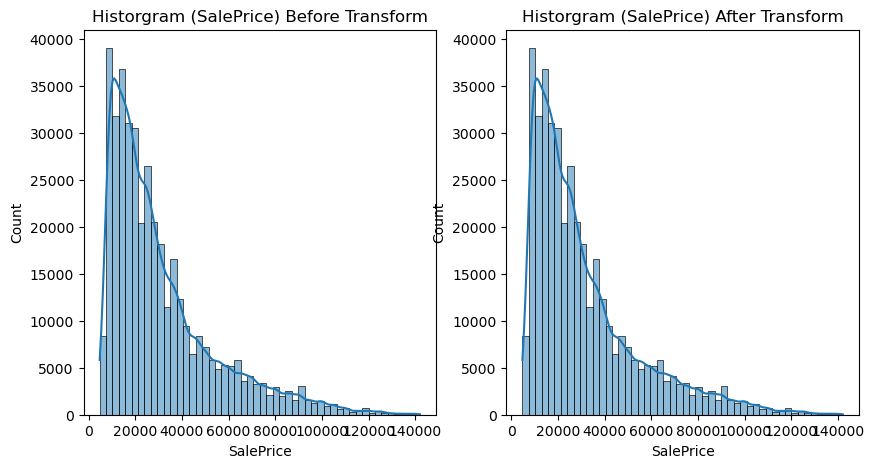

In [46]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5), sharex = False)

sns.histplot(train_data.SalePrice, kde = True, bins = 50, ax = ax[0])
ax[0].title.set_text('Historgram (SalePrice) Before Transform')
sns.histplot(train_df.SalePrice, kde = True, bins = 50, ax = ax[1])              
ax[1].title.set_text('Historgram (SalePrice) After Transform');

### Train - Validation Split

In [47]:
X, y = train_df.drop('SalePrice', axis = 1), train_df.SalePrice
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20)

### Hyperparameter Tuning for `RandomForestRegressor`

In [48]:
%%time
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': np.arange(10, 100, 10),
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 20, 2),
    'max_features': [0.5, 1, 'sqrt', 'log2'],
    'max_samples': [10000]
}

rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions = param_grid,
                              cv = 5,
                              n_iter = 100,
                              verbose = True
                             )

rs_model.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 21min 7s
Wall time: 1h 2min 15s


### Evaluate the randomized model

In [49]:
scores = regression_scores_from_model(rs_model, X_train, y_train, X_val, y_val)
scores

{'Training MAE': 6044.054070698863,
 'Validation MAE': 6166.338142602213,
 'Training RMSLE': 0.2751013567728564,
 'Validation RMSLE': 0.2788663137524668,
 'Training R^2': 0.8364059463527026,
 'Validation R^2': 0.832199848955121}

### Best Parameters

In [50]:
rs_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 10,
 'min_samples_leaf': 5,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

### Load and preprocess the Validation dataset
The **validation set** includes all data in 2012. According to [Dataset Description](https://www.kaggle.com/c/bluebook-for-bulldozers/data?select=Data+Dictionary.xlsx):

* **Valid.csv** is the validation set, which contains data from **January 1, 2012 - April 30, 2012** You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.

In [51]:
valid_data = pd.read_csv('../resources/data/bulldozers/Valid.csv', parse_dates = ['saledate'], low_memory = False)

In [52]:
print(valid_data.shape)
valid_data.head()

(11573, 52)


,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1222837,902859,1376,121,3,1000,0.0,NaN,2012-01-05,375L,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
1,1222839,1048320,36526,121,3,2006,4412.0,Medium,2012-01-05,TX300LC2,...,None or Unspecified,"12' 4""",None or Unspecified,Yes,Double,NaN,NaN,NaN,NaN,NaN
2,1222841,999308,4587,121,3,2000,10127.0,Medium,2012-01-05,270LC,...,None or Unspecified,"12' 4""",None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1222843,1062425,1954,121,3,1000,4682.0,Low,2012-01-05,892DLC,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
4,1222845,1032841,4701,121,3,2002,8150.0,Medium,2012-01-04,544H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional


In [53]:
valid_df = preprocess_data(valid_data)

In [54]:
valid_df.head()

,Backhoe_Mounting,Backhoe_Mounting_is_missing,Blade_Extension,Blade_Extension_is_missing,Blade_Type,Blade_Type_is_missing,Blade_Width,Blade_Width_is_missing,Coupler,Coupler_System,...,fiSecondaryDesc,fiSecondaryDesc_is_missing,saleDay,saleDayOfWeek,saleDayOfYear,saleMonth,saleYear,saledate_is_missing,state,state_is_missing
0,0,1,0,1,0,1,0,1,3,0,...,0,1,5,3,5,1,2012,0,15,0
1,0,1,0,1,0,1,0,1,1,0,...,32,0,5,3,5,1,2012,0,6,0
2,0,1,0,1,0,1,0,1,3,0,...,0,1,5,3,5,1,2012,0,6,0
3,0,1,0,1,0,1,0,1,3,0,...,16,0,5,3,5,1,2012,0,6,0
4,0,1,0,1,0,1,0,1,2,0,...,24,0,4,2,4,1,2012,0,8,0


In [57]:
valid_df.shape, X_train.shape

((11573, 109), (320900, 109))

### Training a model using best hyperparameters

In [58]:
%%time
rf_reg_model_2 = RandomForestRegressor(n_estimators = 90,
                                     min_samples_leaf = 5,
                                     min_samples_split = 10,
                                     max_features = 0.5,
                                     n_jobs = -1
                                    )

rf_reg_model_2.fit(X_train, y_train);

## Scoring the model
### Root Mean Squared Log Error (RMSLE)
**RMSLE** is the evaluation metric for this project as stated in the Dataset Description on Kaggle.
* **RMSLE** is non-negative floating point value (the best value is 0.0),  
* or an array of floating point values, one for each individual target.

In [59]:
scores = regression_scores_from_model(rf_reg_model_2, X_train, y_train, X_val, y_val)
scores

{'Training MAE': 3189.04697483054,
 'Validation MAE': 4498.056517859065,
 'Training RMSLE': 0.15695928457193503,
 'Validation RMSLE': 0.21461924900109228,
 'Training R^2': 0.9502105997172494,
 'Validation R^2': 0.9050472784130613}

### Predictions on the Validation dataset

In [60]:
y_preds_valid = rf_reg_model_2.predict(valid_df)

In [61]:
y_preds_valid

array([29553.71220908, 71276.44672927, 35952.54146634, ...,
       15093.03119629, 17583.88321696, 17723.54685864])

### Visualizing the residues
The residues of regression model should be **normally distributed**.

In [62]:
y_preds_val = rf_reg_model_2.predict(X_val)

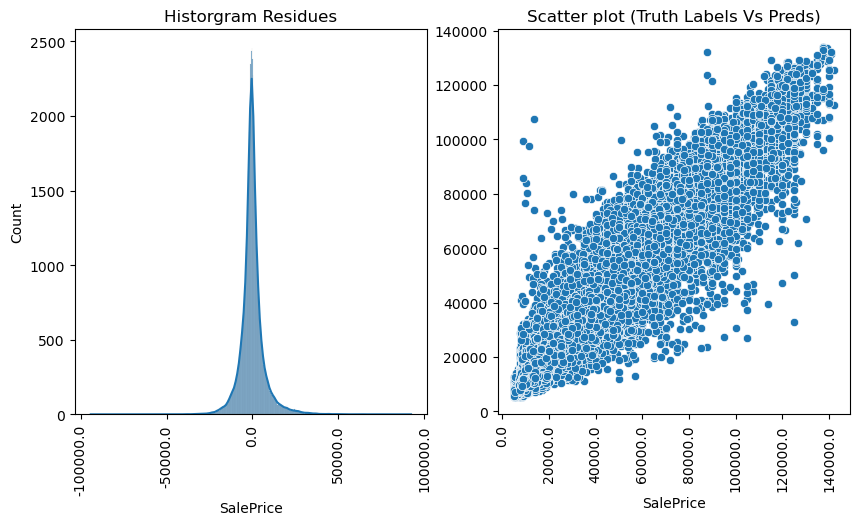

In [63]:
residues = y_val - y_preds_val 

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
sns.histplot(residues, kde = True, ax = ax[0])
ax[0].title.set_text('Historgram Residues')
ax[0].set_xticklabels(ax[0].get_xticks(), rotation = 90)
sns.scatterplot(x = y_val, y = y_preds_val,  ax = ax[1])
ax[1].set_xticklabels(ax[1].get_xticks(), rotation = 90)
ax[1].title.set_text('Scatter plot (Truth Labels Vs Preds)');

### Testing the model (`rf_reg_model_1`) using the test dataset provided
* **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition

In [64]:
df_test = pd.read_csv('../resources/data/bulldozers/Test.csv', parse_dates = ['saledate'], low_memory = False)
print(df_test.shape)
df_test.head()

(12457, 52)


,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


#### Process Test data

In [65]:
test_df = preprocess_data(df_test)

In [66]:
print(test_df.shape)
test_df.head()

(12457, 109)


,Backhoe_Mounting,Backhoe_Mounting_is_missing,Blade_Extension,Blade_Extension_is_missing,Blade_Type,Blade_Type_is_missing,Blade_Width,Blade_Width_is_missing,Coupler,Coupler_System,...,fiSecondaryDesc,fiSecondaryDesc_is_missing,saleDay,saleDayOfWeek,saleDayOfYear,saleMonth,saleYear,saledate_is_missing,state,state_is_missing
0,0,1,0,1,0,1,0,1,0,0,...,25,0,3,3,124,5,2012,0,51,0
1,0,1,0,1,0,1,0,1,3,0,...,0,1,10,3,131,5,2012,0,46,0
2,0,1,0,1,0,1,0,1,3,0,...,9,0,10,3,131,5,2012,0,29,0
3,0,1,0,1,0,1,0,1,3,0,...,13,0,10,3,131,5,2012,0,29,0
4,1,0,0,1,4,0,0,1,0,0,...,33,0,10,3,131,5,2012,0,8,0


In [67]:
z = test_df.isnull().sum()
print(z[z > 0])

Series([], dtype: int64)


### Evaluating the model using preprocessed test dataset

In [68]:
set(list(X_train)) - set(list(test_df))      # find the missing column

set()

In [69]:
%%time
y_preds_test = rf_reg_model_2.predict(test_df)

CPU times: total: 328 ms
Wall time: 151 ms


In [70]:
y_preds_test

array([17677.46046808, 16419.52844709, 47012.72677939, ...,
       12938.2926468 , 16379.53331817, 24650.80774209])

In [71]:
len(y_preds_test)

12457

### Formatting the results as indicated by Kaggle
https://www.kaggle.com/c/bluebook-for-bulldozers/overview 

* Have a header: "SalesID,SalePrice"
* Contain two columns
    * **SalesID**: SalesID for the validation set in sorted order
    * **SalePrice**: Your predicted price of the sale

In [72]:
df_results = pd.DataFrame()
df_results['SalesID'] = test_df.SalesID
df_results['SalePrice'] = y_preds_test
df_results.head()

,SalesID,SalePrice
0,1227829,17677.460468
1,1227844,16419.528447
2,1227847,47012.726779
3,1227848,67601.066637
4,1227863,57119.199468


### Save results as `.csv`

In [73]:
df_results.to_csv('./model_preds/bulldozers_price_predictions_3.csv', index = False)

### Persisting the model

In [74]:
joblib.dump(rf_reg_model_2, './model_preds/rf_reg_bulldozers_price_prediction_model_best_2.joblib');

### Feature Importance

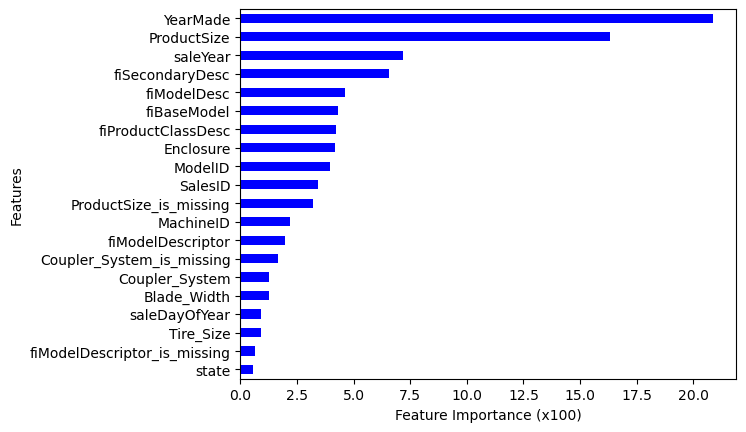

In [75]:
fig = plot_feature_importance(rf_reg_model_2, X_train, 20)

### Feature Selection using `PCA`
The model would certain not live with a whopping **109 features**! To reduce the effect known as the ***curse of dimensionality*** I used **PCA** to generate **25 features** from the **109**. The result is a **drastic reduction in training time to under 3 minutes** (on my laptop) with a comparable RMSLE. There is always a trade-off in efficiency or whatever evaluation metrics because **PCA always involves some loss in information**.

In [76]:
X_train.shape, X_val.shape

((320900, 109), (80225, 109))

In [77]:
pca = PCA(n_components = 25, svd_solver = 'full')
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
X_valid_pca = pca.transform(valid_df)
X_test_pca = pca.transform(test_df)

In [78]:
%%time
rf_reg_pca_2 = RandomForestRegressor(n_estimators = 90,
                                     min_samples_leaf = 5,
                                     min_samples_split = 10,
                                     max_features = 0.5,
                                     n_jobs = -1
                                    )

rf_reg_pca_2.fit(X_train_pca, y_train);

CPU times: total: 43min 31s
Wall time: 8min 4s


In [80]:
scores_pca = regression_scores_from_model(rf_reg_pca_2, X_train_pca, y_train, X_val_pca, y_val)
scores_pca

{'Training MAE': 3685.3009325729236,
 'Validation MAE': 5918.112257678947,
 'Training RMSLE': 0.18043020404882076,
 'Validation RMSLE': 0.2723055758515113,
 'Training R^2': 0.9336144281442814,
 'Validation R^2': 0.8405386431759303}

### Prediction using the test dataset

In [81]:
y_preds_test_pca = rf_reg_pca_2.predict(X_test_pca)
y_preds_test_pca

array([14430.56221973, 16137.60934359, 33787.39190979, ...,
       42444.19259399, 52210.23470402, 53505.60938698])

### Presenting the results as required by Kaggle

In [82]:
df_results = pd.DataFrame()
df_results['SalesID'] = test_df.SalesID
df_results['SalePrice'] = y_preds_test_pca
df_results.head()

,SalesID,SalePrice
0,1227829,14430.562220
1,1227844,16137.609344
2,1227847,33787.391910
3,1227848,29296.342159
4,1227863,29349.780947


In [83]:
df_results.to_csv('./model_preds/bulldozers_price_predictions_pca_2.csv', index = False)

In [84]:
joblib.dump(rf_reg_pca_2, './model_preds/rf_reg_bulldozers_price_prediction_model_pca_2.joblib');